In [34]:
import feets
import os 
import math 
import numpy as np 
import argparse 
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.vizier import Vizier
import sys
import hdbscan
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
fft = False
import pickle
import matplotlib.pylab as pylab
from astropy.table import Table, Column, join 


# Step 1: Reading in the light curves, save as seperate ascii files 

In [9]:
df = pd.read_hdf('/Users/swebb/Documents/renee/lmc_rawdata_sample.h5', 'df', mode='r')
#replace NaNs with zeros to help with feature extaction later on 
df = df.replace(np.nan, 0)
print(df)

                hjd        mag    magerr  type  contam   chp       xp  \
objid                                                                   
54     58833.526351  21.120489  0.011924   1.0     0.0  28.0   910.06   
125    58833.526351  20.617530  0.011911   1.0     0.0  24.0  1194.42   
130    58833.526351  20.795530  0.011911   1.0     0.0  24.0  1119.04   
747    58833.526351  22.634489  0.021824   1.0     0.0  28.0  1906.37   
783    58833.526351  22.235489  0.017844   1.0     0.0  28.0  1369.97   
...             ...        ...       ...   ...     ...   ...      ...   
7487   58833.526351  24.485530  0.094776   1.0     0.0  24.0   619.99   
11164  58833.526351  25.366530  0.217772   7.0     0.0  24.0  1982.92   
11371      0.000000   0.000000  0.000000   0.0     0.0   0.0     0.00   
6654   58833.526351  24.828489  0.122771   7.0     0.0  28.0   694.27   
11143      0.000000   0.000000  0.000000   0.0     0.0   0.0     0.00   

            yp    bfloor   moffset  ...       xp  

In [10]:
#save each objects lightcurve as a single ascii file 

for index, row in df.iterrows():
    hjd = []
    mag = []
    magerr = []
    for i in row.hjd: 
        hjd.append(i)
    for i in row.mag:
        mag.append(i)
    for i in row.magerr:
        magerr.append(i)
    object_table = Table()
    object_table['HJD'] = hjd
    object_table['mag'] = mag
    object_table['magerr'] = magerr
    file_name= '/Users/swebb/Documents/renee/LC_files/objectID_'+str(index)+'_lc.ascii'
    object_table.write(file_name, format='ascii', overwrite=True)
    #print(object_table)

# Step 2: Reading in the light curves for features 

In [29]:
def get_feats_blank():
    path = '/Users/swebb/Documents/renee/LC_files/'
    lc_with_only_zeros = []
    used_lcs = []
    filenames = []
    
    Autocor_length = []
    Beyond1Std = []
    CAR_sigma = []
    CAR_mean = []
    CAR_tau =[]
    Con =[]
    Eta_e = []
    LinearTrend = []
    MaxSlope =[]
    Mean = []
    Meanvariance = []
    MedianAbsDev =[]
    MedianBRP =[]
    PairSlopeTrend =[]
    PercentAmplitude =[]
    Q31 =[]
    Rcs =[]
    Skew =[]
    SlottedA_length =[]
    SmallKurtosis =[]
    Std = []
    StetsonK_AC = []
    Amplitudes = []
    VariabilityIndex = []
    hl_ratio = []
    amp1_val = []
    amp_2_1_ratio = []
    amp_3_1_ratio = []
    phase_2_1_ratio = []
    phase_3_1_ratio = []
    files = os.listdir(path)
    for filename in files: 
        if filename.endswith('lc.ascii'):
            try:
                hjd, mag, emag = np.loadtxt(path + filename, unpack = True, skiprows=1)
            except: 
                print('FILE EMPTY)')
            sum_mag = np.sum(mag)
            #print(filename, sum_mag)
            if sum_mag == 0:
                lc_with_only_zeros.append(filename)
            elif sum_mag != 0:
                used_lcs.append(filename)
            clean_hjd = []
            clean_mag = []
            clean_emag = []
            for l,m,n in zip(hjd,mag, emag):
                if m != 0:
                    if m != 0:
                        clean_hjd.append(l)
                        clean_mag.append(m)
                        clean_emag.append(n)
                    elif m != float: 
                        pass 
            if len(clean_hjd) > 3:
                lc = np.array([clean_mag, clean_hjd, clean_emag])
                fs=feets.FeatureSpace(only=['Autocor_length', 'Beyond1Std', 'CAR_sigma', 'CAR_mean',
                                            'CAR_tau', 'Con', 'LinearTrend', 'MaxSlope',
                                            'Mean', 'Meanvariance', 'MedianAbsDev', 'MedianBRP',
                                            'PairSlopeTrend', 'PercentAmplitude', 'Q31', 'Rcs', 'Skew',
                                            'SlottedA_length', 'SmallKurtosis', 'Std',
                                            'StetsonK_AC' ])
                features, values = fs.extract(*lc)
                results = dict(zip(features,values))
                filenames.append(filename)
                Autocor_length.append(results['Autocor_length'])
                Beyond1Std.append(results['Beyond1Std'])
                CAR_sigma.append(results['CAR_sigma'])
                CAR_mean.append(results['CAR_mean'])
                CAR_tau.append(results['CAR_tau'])
                Con.append(results['Con'])
                LinearTrend.append(results['LinearTrend'])
                MaxSlope.append(results['MaxSlope'])
                Mean.append(results['Mean'])
                Meanvariance.append(results['Meanvariance'])
                MedianAbsDev.append(results['MedianAbsDev'])
                MedianBRP.append(results['MedianBRP'])
                PairSlopeTrend.append(results['PairSlopeTrend'])
                PercentAmplitude.append(results['PercentAmplitude'])
                Q31.append(results['Q31'])
                Rcs.append(results['Rcs'])
                Skew.append(results['Skew'])
                SlottedA_length.append(results['SlottedA_length'])
                SmallKurtosis.append(results['SmallKurtosis'])
                Std.append(results['Std'])
                StetsonK_AC.append(results['StetsonK_AC'])
                N = len(clean_mag)
                sorted_mag = np.sort(clean_mag)
                amp = (np.median(sorted_mag[-int(math.ceil(0.05*N)):]) - np.median(sorted_mag[0:int(math.ceil(0.05*N))])) / 2
                Amplitudes.append(amp)
                clean_mag_array = np.asarray(clean_mag)
                sigma2 = np.var(clean_mag)
                VarIndex = 1/((N-1)*sigma2)*np.sum(np.power(clean_mag_array[1:]-clean_mag_array[:-1], 2))
                VariabilityIndex.append(VarIndex)
                non_detects = []
                fft = np.fft.rfft(clean_mag)
                amps = np.sqrt(fft.real**2+fft.imag**2)
                amp1 = amps[0]
                amp1_val.append(amp1)
                amp2 = amps[1]
                amp3 = amps[2]
                amp_2_1 = amp2/amp1
                amp_3_1 = amp3/amp1 
                amp_2_1_ratio.append(amp_2_1)
                amp_3_1_ratio.append(amp_3_1)
                phases = np.arctan2(fft.imag, fft.real)
                phase1 = phases[0]
                phase2 = phases[1]
                phase3 = phases[2]
                phase_2_1 = phase2/phase1
                phase_3_1 = phase3/phase1  
                phase_2_1_ratio.append(phase_2_1)
                phase_3_1_ratio.append(phase_3_1)
            else: 
                print('Not enough data points')
    feature_table = Table()
    feature_table['LC_name'] = filenames
    feature_table['Autocor_length'] = Autocor_length
    feature_table['Beyond1Std'] = Beyond1Std
    feature_table['CAR_sigma'] = CAR_sigma
    feature_table['CAR_mean'] = CAR_mean
    feature_table['CAR_tau'] = CAR_tau
    feature_table['Con'] = Con
    feature_table['LinearTrend'] = LinearTrend
    feature_table['MaxSlope'] = MaxSlope
    feature_table['Mean'] =Mean
    feature_table['Meanvariance'] =Meanvariance
    feature_table['MedianAbsDev'] =MedianAbsDev
    feature_table['MedianBRP'] =MedianBRP
    feature_table['PairSlopeTrend'] =PairSlopeTrend
    feature_table['PercentAmplitude'] =PercentAmplitude
    feature_table['Q31'] =Q31
    feature_table['Rcs'] =Rcs
    feature_table['Skew'] =Skew
    feature_table['SlottedA_length'] =SlottedA_length
    feature_table['SmallKurtosis'] =SmallKurtosis
    feature_table['Std'] =Std
    feature_table['StetsonK_AC'] =StetsonK_AC
    feature_table['Amplitudes'] = Amplitudes
    #feature_table['VariabilityIndex'] = VariabilityIndex 
    feature_table['amp1'] = amp1_val
    feature_table['amp_2_1_ratio'] = amp_2_1_ratio 
    feature_table['amp_3_1_ratio'] = amp_3_1_ratio
    #feature_table['phase_2_1_ratio'] = phase_2_1_ratio
    #feature_table['phase_3_1_ratio'] = phase_3_1_ratio
    output ='/Users/swebb/Documents/renee/feature_files/features_test_set.csv'
    df = feature_table.to_pandas()
    df = df.replace(np.nan, 0)
    df.to_csv(output)
    return feature_table

In [30]:
get_feats_blank()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divid

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divid

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rc

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/pytho

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rc

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divid

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/ana

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.6/site-packages/feets/extractors/ext_stetson.py:248: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(np.abs(sigmap)) / np.sqrt(np.sum(sigmap ** 2)))
/anaconda3/lib/python3.6/

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/pytho

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/ipy

/anaconda3/lib/python3.6/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divid

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/ana

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/ana

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.6/site-packages/feets/extractors/ext_stetson.py:248: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(np.abs(sigmap)) / np.sqrt(np.sum(sigmap ** 2)))
/anaconda3/lib/python3.6/

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/sta

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/ipy

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/num

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/feets/extractors/ext_max_slope.py:91: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.abs(magnitude[1:] - magnitude[:-1]) / (time[1:] - time[:-1])
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountere

LC_name,Autocor_length,Beyond1Std,CAR_sigma,CAR_mean,CAR_tau,Con,LinearTrend,MaxSlope,Mean,Meanvariance,MedianAbsDev,MedianBRP,PairSlopeTrend,PercentAmplitude,Q31,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK_AC,Amplitudes,amp1,amp_2_1_ratio,amp_3_1_ratio
str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
objectID_11194_lc.ascii,113.0,0.39539347408829173,10.0,117667.38377919386,0.5,0.0,0.06520242750660331,175633.99981871923,58833.69188959693,1.5683732459424062e-06,0.07884200000262354,0.2053742802303263,0.9666666666666667,2.772408011988761e-06,0.1568970000007539,0.43134354074167824,-0.04444164947307508,nan,-1.1657285830238244,0.09227318831966255,0.9999999999999998,0.1525925000000008,13338.991988000005,0.0001788710211497675,0.0002146617581229562
objectID_9603_lc.ascii,118.0,0.4,10.0,117667.38552437408,0.5,0.0,0.16931158787554654,inf,58833.69276218704,1.5740806977676745e-06,0.07937550000133342,0.20185185185185187,0.9666666666666667,2.8457247198093075e-06,0.1588812499976484,0.4328314900373134,-0.047389832596435075,1.0,-1.1856203947738029,0.09260898015535236,1.0,0.17041549999999894,13729.836817,0.0006379839466374241,8.976680071445384e-05
objectID_7128_lc.ascii,124.0,0.40421792618629176,10.0,117667.37632486116,0.5,0.0,-0.25382563883447007,130125.99986989252,58833.68816243058,1.5945686531939446e-06,0.08147400000598282,0.19859402460456943,0.9666666666666667,2.7623629619212803e-06,0.16262199999619043,0.43339354165836047,0.003823580645336117,nan,-1.1990697256859806,0.09381435489559946,nan,0.08612150000000085,14166.605930999996,0.00015004747274399138,7.235866022356251e-05
objectID_11385_lc.ascii,117.0,0.39814814814814814,10.0,117667.38384618149,0.5,0.0,0.21783638452197623,192470.99980426324,58833.691923090744,1.5786725254645266e-06,0.07930800000031013,0.2037037037037037,0.9666666666666667,2.8358920022478793e-06,0.15831975000037346,0.4315714695240064,-0.04671112391622811,1.0,-1.1603881563675202,0.09287913301062758,1.0,0.19490850000000037,13859.977020999999,0.0007320376208168352,0.0003412687315597772
objectID_6788_lc.ascii,124.0,0.40492957746478875,10.0,117667.37715585211,0.5,0.0,-0.3860321981237948,inf,58833.688577926056,1.5933710276683862e-06,0.08102950000102283,0.198943661971831,0.9666666666666667,2.758054166055268e-06,0.16177900000911904,0.4331092377234636,-0.005540189579912094,nan,-1.1941467662334155,0.09374389483093183,nan,0.09331050000000118,14153.774879,0.00016083803594997136,0.00014407934499238408
objectID_5180_lc.ascii,125.0,0.4077328646748682,10.0,117667.37649873112,0.5,0.0,1.1517218548355135,123207.00031525361,58833.68824936556,1.59488765044581e-06,0.08148899999650894,0.1968365553602812,0.9666666666666667,2.7532525085992187e-06,0.16262199999619043,0.4336862295737431,0.0012362709031073986,nan,-1.2004383434717503,0.0938331228190919,nan,0.12682549999999893,13654.84938599999,0.001507393298761554,0.0006566716050050094
objectID_13043_lc.ascii,123.0,0.40425531914893614,10.0,117667.37833348935,0.5,0.0,-0.12154369984156758,101893.00025636383,58833.689166744676,1.5924542987564589e-06,0.08131100000173319,0.19858156028368795,0.9666666666666667,2.7673939995462066e-06,0.16234875000372995,0.433272409839201,-0.01234496285690415,1.0,-1.196160432428087,0.09368996122528386,1.0,0.10759650000000143,14128.769772,0.0002627947154663194,0.00016981358954282143
objectID_783_lc.ascii,125.0,0.42105263157894735,10.0,117667.37648286665,0.5,0.0,1.6706058924881622,43875.99995826272,58833.68824143332,1.5934912576761697e-06,0.08131099999809521,0.19824561403508772,0.9666666666666667,2.7575272837000535e-06,0.16234075000829762,0.43334705836919707,0.001490981310478565,nan,-1.1972733490992156,0.09375096786956927,nan,0.0952130000000011,12735.394897,0.0011724307686320236,0.000573821734561999
objectID_7803_lc.ascii,125.0,0.4105263157894737,10.0,117667.37648286665,0.5,0.0,-0.4352042641872577,263103.99972737895,58

# Step 3: Cluster the features 

In [3]:
filename = 'features_test_set.csv'
filepath = "/Users/swebb/Documents/renee/feature_files/"+filename
df = pd.read_csv(filepath, delimiter=',')
df.replace([np.inf, -np.inf], 0)
df = df.replace(np.nan, 0)
print(df)

     Unnamed: 0                  LC_name  Autocor_length  Beyond1Std  \
0             0  objectID_11194_lc.ascii           113.0    0.395393   
1             1   objectID_9603_lc.ascii           118.0    0.400000   
2             2   objectID_7128_lc.ascii           124.0    0.404218   
3             3  objectID_11385_lc.ascii           117.0    0.398148   
4             4   objectID_6788_lc.ascii           124.0    0.404930   
..          ...                      ...             ...         ...   
130         130  objectID_12687_lc.ascii           107.0    0.404959   
131         131   objectID_8017_lc.ascii           124.0    0.406690   
132         132   objectID_6819_lc.ascii           123.0    0.406750   
133         133  objectID_10841_lc.ascii            92.0    0.389151   
134         134   objectID_6910_lc.ascii           125.0    0.408772   

     CAR_sigma       CAR_mean  CAR_tau  Con  LinearTrend      MaxSlope  ...  \
0         10.0  117667.383779      0.5  0.0     0.065202

In [4]:
LC_name = []
Autocor_length = []
Beyond1Std = []
CAR_sigma = []
CAR_mean= []
CAR_tau= []
Con= []
LinearTrend= []
MaxSlope= []
Mean= []
Meanvariance= []
MedianAbsDev= []
MedianBRP= []
PairSlopeTrend= []
PercentAmplitude= []
Q31= []
Rcs= []
Skew= []
SlottedA_length= []
SmallKurtosis= []
Std= []
StetsonK_AC= []
Amplitudes= []
Amp1= []
Amp_2_1_ratio= []
Amp_3_1_ratio = []
for index, row in df.iterrows():
    LC_name.append(row.LC_name)
    Autocor_length.append(row.Autocor_length)
    Beyond1Std.append(row.Beyond1Std)
    CAR_sigma.append(row.CAR_sigma)
    CAR_mean.append(row.CAR_mean)
    CAR_tau.append(row.CAR_tau)
    Con.append(row.Con)
    LinearTrend.append(row.LinearTrend)
    MaxSlope.append(row.MaxSlope)
    Mean.append(row.Mean)
    Meanvariance.append(row.Meanvariance)
    MedianAbsDev.append(row.MedianAbsDev)
    MedianBRP.append(row.MedianBRP)
    PairSlopeTrend.append(row.PairSlopeTrend)
    PercentAmplitude.append(row.PercentAmplitude)
    Q31.append(row.Q31)
    Rcs.append(row.Rcs)
    Skew.append(row.Skew)
    SlottedA_length.append(row.SlottedA_length)
    SmallKurtosis.append(row.SmallKurtosis)
    Std.append(row.Std)
    StetsonK_AC.append(row.StetsonK_AC)
    Amplitudes.append(row.Amplitudes)
    Amp1.append(row.amp1)
    Amp_2_1_ratio.append(row.amp_2_1_ratio)
    Amp_3_1_ratio.append(row.amp_3_1_ratio)
    
    
#Beyond1Std, CAR_sigma, CAR_mean, CAR_tau, Con, LinearTrend, MaxSlope, Mean, Meanvariance, MedianAbsDev, MedianBRP, PairSlopeTrend, PercentAmplitude, Q31, Rcs, Skew, SlottedA_length, SmallKurtosis, Std, StetsonK_AC, Amplitudes, Amp1, Amp_2_1_ratio, Amp_3_1_ratio = np.loadtxt(filepath, unpack = True, skiprows=1)

In [5]:
dict = {'Filename': LC_name, 'Autocor_length': Autocor_length, 
        'Beyond1Std' : Beyond1Std, 'CAR_sigma': CAR_sigma, 
        'CAR_mean': CAR_mean, 'CAR_tau':CAR_tau, 'Con':Con, 
        'LinearTrend': LinearTrend, 
        'MaxSlope':MaxSlope, 'Mean' : Mean, 
        'Meanvariance': Meanvariance, 'MedianAbsDev': MedianAbsDev,
        'MedianBRP' : MedianBRP, 'PairSlopeTrend' : PairSlopeTrend, 
        'PercentAmplitude' : PercentAmplitude, 'Q31':Q31, 'Rcs':Rcs,
        'Skew':Skew, 'SlottedA_length' :SlottedA_length,
        'SmallKurtosis':SmallKurtosis, 'Std':Std, 
        'StetsonK_AC':StetsonK_AC, 'Amplitudes':Amplitudes,
        'Amp1': Amp1, 'Amp_2_1_ratio': Amp_2_1_ratio, 'Amp_3_1_ratio': Amp_3_1_ratio}

In [6]:
#Put dictionary into a pandas datadframe #
dframe = pd.DataFrame(dict)
dframe.replace('inf', 0)
dframe = dframe.replace(np.nan, 0)
print(len(dframe))
print(dframe)

135
                    Filename  Autocor_length  Beyond1Std  CAR_sigma  \
0    objectID_11194_lc.ascii           113.0    0.395393       10.0   
1     objectID_9603_lc.ascii           118.0    0.400000       10.0   
2     objectID_7128_lc.ascii           124.0    0.404218       10.0   
3    objectID_11385_lc.ascii           117.0    0.398148       10.0   
4     objectID_6788_lc.ascii           124.0    0.404930       10.0   
..                       ...             ...         ...        ...   
130  objectID_12687_lc.ascii           107.0    0.404959       10.0   
131   objectID_8017_lc.ascii           124.0    0.406690       10.0   
132   objectID_6819_lc.ascii           123.0    0.406750       10.0   
133  objectID_10841_lc.ascii            92.0    0.389151       10.0   
134   objectID_6910_lc.ascii           125.0    0.408772       10.0   

          CAR_mean  CAR_tau  Con  LinearTrend      MaxSlope          Mean  \
0    117667.383779      0.5  0.0     0.065202  1.756340e+05  58833

In [7]:
#Define what features to use in the clustering, don't cluster on the targert/ID names! # 
features = ['Autocor_length', 'Beyond1Std', 'CAR_sigma', 'CAR_mean', 
            'CAR_tau', 'Con', 'LinearTrend', 
            'Mean', 'Meanvariance', 'MedianAbsDev', 'MedianBRP', 
            'PairSlopeTrend', 'Q31', 'Rcs', 'Skew', 'SlottedA_length',
            'SmallKurtosis', 'Std', 'StetsonK_AC', 'Amplitudes',
            'Amp1', 'Amp_2_1_ratio', 'Amp_3_1_ratio']

In [8]:
## Separating out the features:
x = dframe.loc[:, features].values
## Separating out the LC names:
y = dframe.loc[:,['Filename']].values
# Standardise the features
x = StandardScaler().fit_transform(x)

In [9]:

## Simple 2D component breakdown ##

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns =['PC1', 'PC2'])
finalDf = pd.concat([principalDf, dframe[['Filename']]], axis =1)

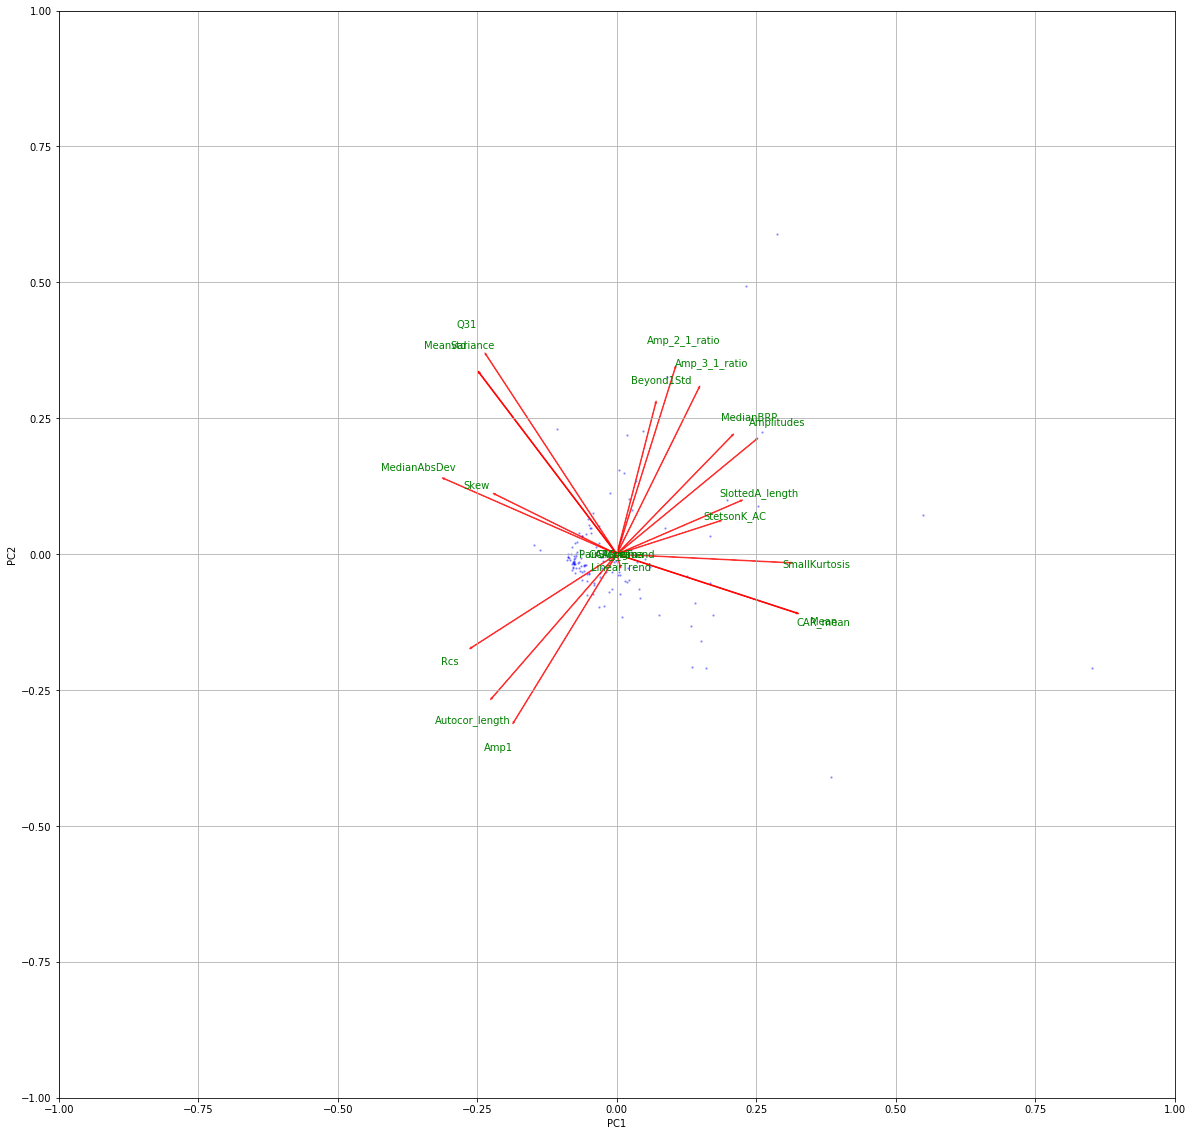

['Autocor_length', 'Beyond1Std', 'CAR_sigma', 'CAR_mean', 'CAR_tau', 'Con', 'LinearTrend', 'Mean', 'Meanvariance', 'MedianAbsDev', 'MedianBRP', 'PairSlopeTrend', 'Q31', 'Rcs', 'Skew', 'SlottedA_length', 'SmallKurtosis', 'Std', 'StetsonK_AC', 'Amplitudes', 'Amp1', 'Amp_2_1_ratio', 'Amp_3_1_ratio']


In [10]:
def myplot(score, coeff, labels=None):
        xs = score[:,0]
        ys = score[:,1]
        n = coeff.shape[0]
        scalex = 1.0/(xs.max() - xs.min())
        scaley = 1.0/(ys.max() - ys.min())
        plt.scatter(xs*scalex, ys*scaley, c ='b' , alpha =0.3, s =2)
        for i in range(n):
                plt.arrow(0,0, coeff[i,0], coeff[i,1], color = 'r', alpha =0.7)
                if labels is None:
                        plt.text(coeff[i,0]*1.15, coeff[i,1] *1.15, "Var"+str(i+1), color="hotpink", ha = 'center', va = 'center')
                else:
                        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
fig = plt.figure(figsize=(20,20))
plt.xlim(-1,1)
plt.ylim(-1, 1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()
myplot(principalComponents[:,0:2],np.transpose(pca.components_[0:2, :]), labels=features)
plt.show()
print(features)

In [11]:
tsne =TSNE(n_components=2, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(x)
clusterer = hdbscan.HDBSCAN(metric='euclidean')
hdbscan_result = clusterer.fit(x)
hdbscan_result.labels_
hdbscan_result.labels_.max()
labels = hdbscan_result.labels_
n_clusters_ = len(set(labels))-(1 if -1 in labels else 0)
print(n_clusters_)

3


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)


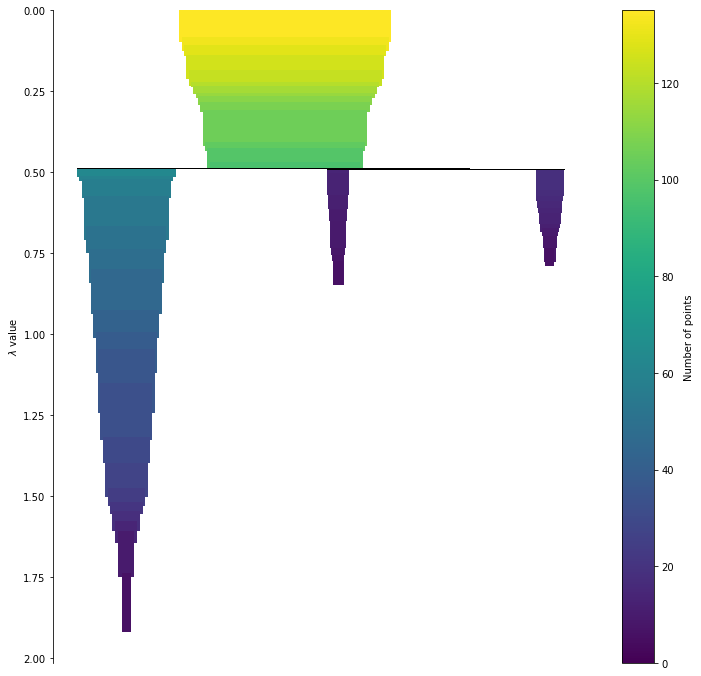

In [12]:
print(hdbscan_result)
fig = plt.figure(figsize=(12,12))
clusterer.condensed_tree_.plot()

In [15]:
features = x
filenames = np.array(y)
cluster_score = np.array(hdbscan_result.labels_)
cluster_score_reshape = cluster_score.reshape(len(x),1)
filenames_features = np.append(filenames, features ,axis=1)
#print(filenames_features)
filenames_features_clusters = np.append(filenames_features, cluster_score_reshape, axis=1)
print(np.shape(filenames_features_clusters))

(135, 25)


Text(0, 0.5, 'Number of Light Curves')

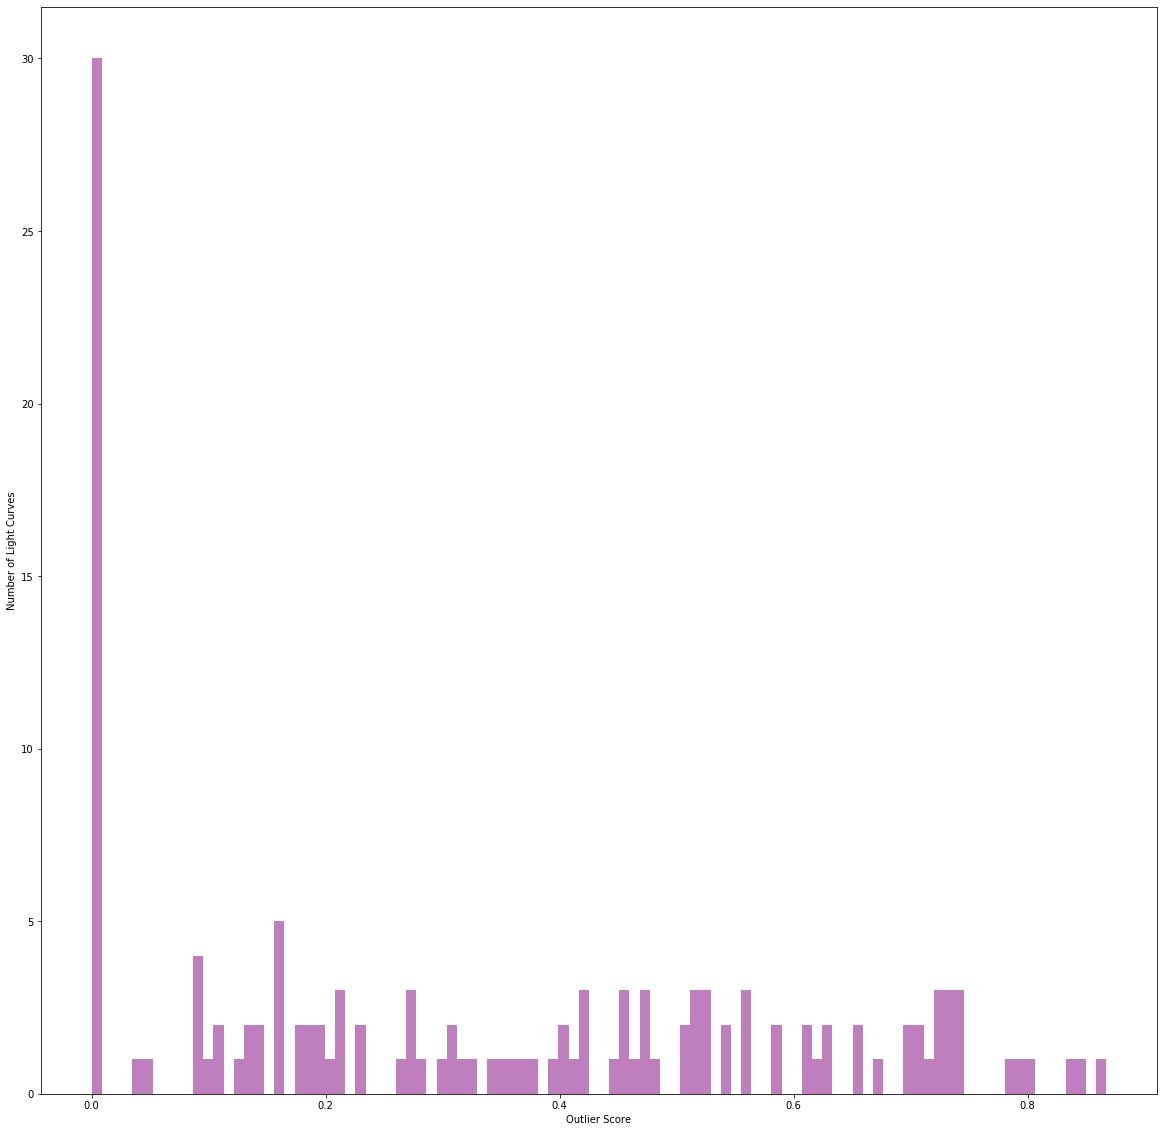

In [20]:
## clusterer.outlier_scores_
fig = plt.figure(figsize=(20,20))
plt.hist(clusterer.outlier_scores_, bins=100, color='purple', alpha=0.5)
plt.xlabel('Outlier Score')
plt.ylabel('Number of Light Curves')

In [21]:
tsne = tsne_results 
filenames = np.array(y)
cluster_score = np.array(hdbscan_result.labels_)
cluster_score_reshape = cluster_score.reshape(len(x),1)
tsne_filenames = np.append(filenames, tsne, axis=1)
tsne_filenames_clusters = np.append(tsne_filenames,cluster_score_reshape, axis=1 )
print(tsne_filenames_clusters)

[['objectID_11194_lc.ascii' 9.504554748535156 6.332859516143799 -1]
 ['objectID_9603_lc.ascii' 9.403512954711914 5.035561561584473 -1]
 ['objectID_7128_lc.ascii' -3.9007773399353027 -3.3430938720703125 0]
 ['objectID_11385_lc.ascii' 8.743670463562012 5.809609413146973 -1]
 ['objectID_6788_lc.ascii' -2.9819178581237793 -4.014692306518555 0]
 ['objectID_5180_lc.ascii' -7.302534103393555 2.0495944023132324 0]
 ['objectID_13043_lc.ascii' 8.932300567626953 -0.841793417930603 2]
 ['objectID_783_lc.ascii' -8.0951509475708 3.719960927963257 -1]
 ['objectID_7803_lc.ascii' 8.590982437133789 -1.5505739450454712 2]
 ['objectID_2644_lc.ascii' 4.579222679138184 -0.9445338249206543 1]
 ['objectID_4110_lc.ascii' -6.459569931030273 0.5855513215065002 0]
 ['objectID_4504_lc.ascii' 1.4837172031402588 4.831570148468018 -1]
 ['objectID_4995_lc.ascii' -6.7130279541015625 2.360354423522949 0]
 ['objectID_2400_lc.ascii' -6.708102226257324 2.345305919647217 0]
 ['objectID_11907_lc.ascii' -0.6472008228302002 -2

In [22]:
def get_cmap(n, name='nipy_spectral'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

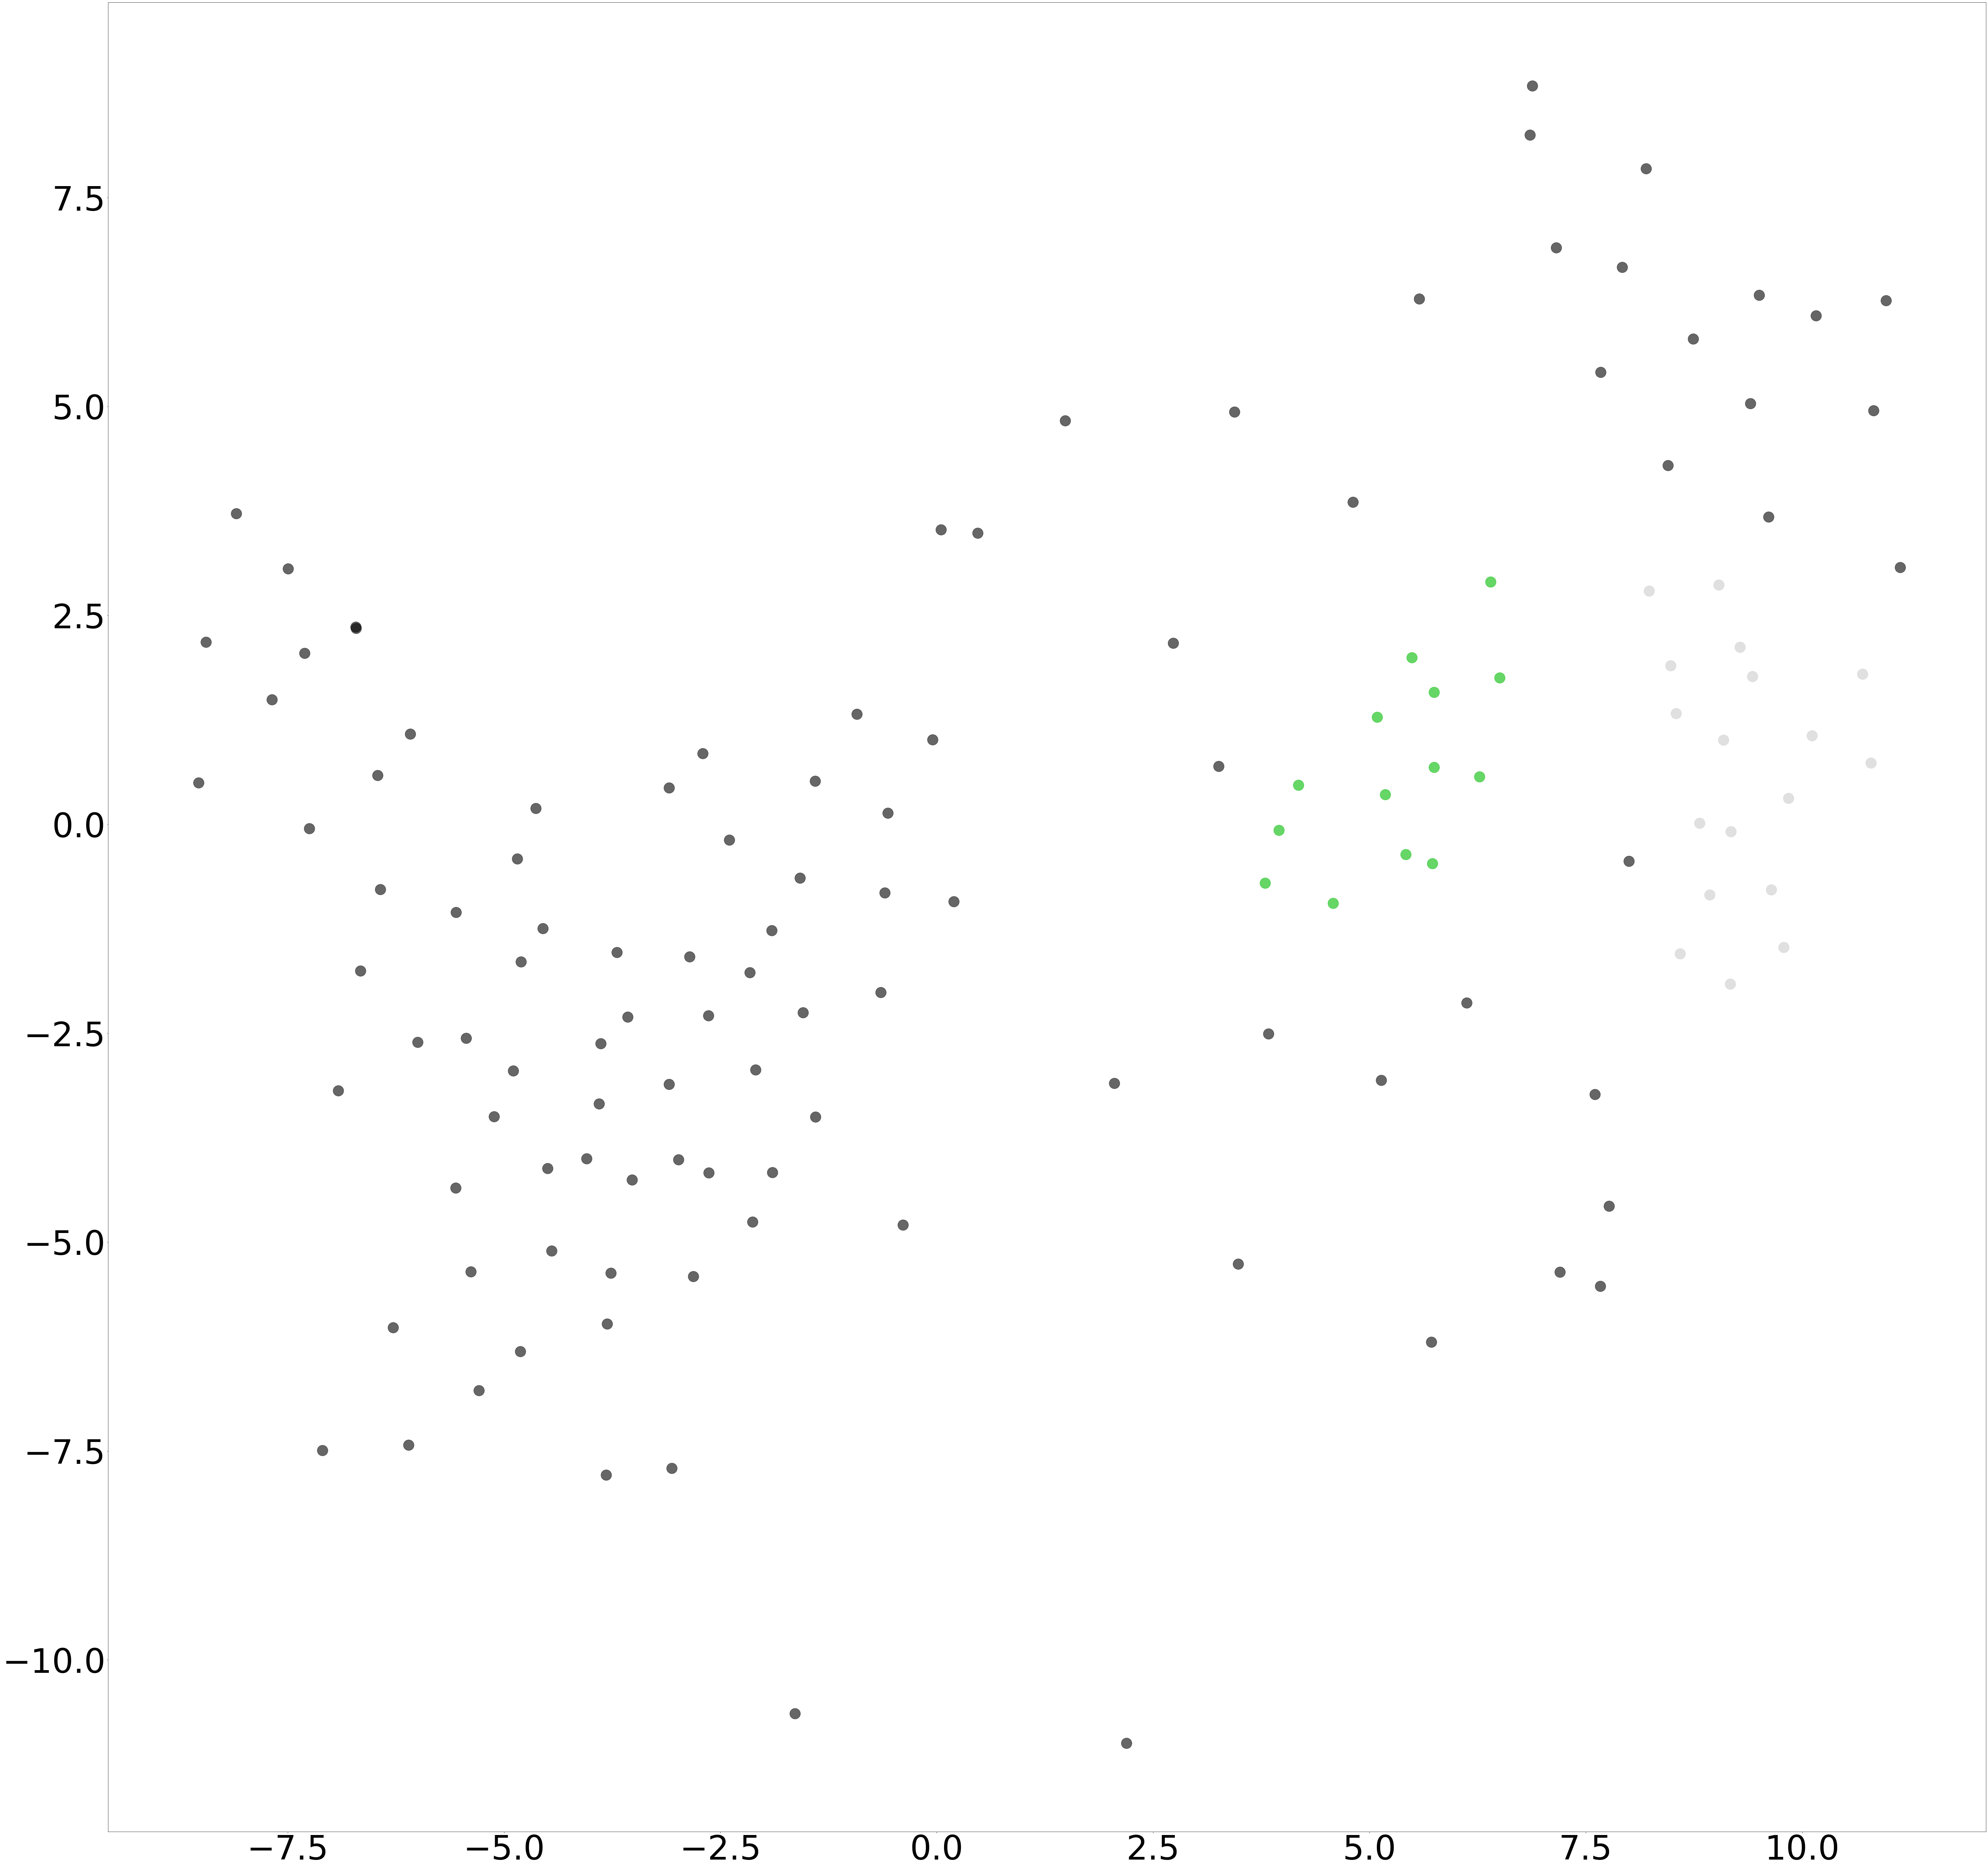

In [28]:
cmap = get_cmap(n_clusters_)
fig = plt.figure(figsize=(100,100))
ax = fig.add_subplot(111)

params = {'legend.fontsize': 'x-large',
          'legend.fontsize': 100,
          'legend.handlelength': 2,
          'figure.figsize': (100, 100),
         'axes.labelsize': '100',
         'axes.titlesize':'100',
         'xtick.labelsize':'100',
         'ytick.labelsize':'100'}
pylab.rcParams.update(params)

for cluster in np.unique(tsne_filenames_clusters[:,3]):
    #msk = np.where(tsne_filenames_clusters[:,4]==cluster)[0]
    msk = np.where(tsne_filenames_clusters[:,3]==cluster)[0]
    xx = tsne_filenames_clusters[msk,1]
    yy = tsne_filenames_clusters[msk,2]
    ax.scatter(xx, yy, alpha=0.6, label=cluster, c=cmap(cluster), s=1000)

In [35]:
# save clusters for looking 
d = {}
for cluster in np.unique(tsne_filenames_clusters[:,3]):
    #print(cluster)
    msk = np.where(tsne_filenames_clusters[:,3]==cluster)[0]
    #print(tsne_filenames_clusters[:,0])
    d["cluster{0}".format(cluster)] = tsne_filenames_clusters[msk,0]
    xx = tsne_filenames_clusters[msk,1]
    yy = tsne_filenames_clusters[msk,2]
   #print(tsne_filenames_clusters)
f = open(filename+'_clsuters.pkl', "wb")
pickle.dump(d, f)
f.close()